In [1]:
import pandas as pd
import numpy as np
import torch
import os

from fairseq_signals.data.ecg.raw_ecg_dataset import FileECGDataset, NpECGDataset, DataframeECGDataset
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, f1_score, accuracy_score, balanced_accuracy_score
import torchmetrics.functional.classification as Fc

from scipy.stats import spearmanr, linregress
from torchmetrics import R2Score, MeanAbsoluteError, MeanSquaredError
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm 
import functools

/root/miniconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/miniconda3/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def try_catch_fn(fn, default_val=np.nan):
    try:
        result = fn()
        # Convert tensor to a scalar if applicable
        if isinstance(result, torch.Tensor):
            return result.item()
        return result
    except Exception as e:
        print('Error occurred when evaluating metrics:', e)
        return default_val

def stable_sigmoid(x):
    x_safe = np.clip(x, -500, 500)
    return np.where(x_safe >= 0,
                    1 / (1 + np.exp(-x_safe)),
                    np.exp(x_safe) / (1 + np.exp(x_safe)))

def find_optimal_threshold_youden_index_multilabel(true_labels, pred_scores):
    optimal_thresholds = []
    youden_indices = []

    for i in range(true_labels.shape[1]):
        fpr, tpr, thresholds = roc_curve(true_labels[:, i], pred_scores[:, i])
        youden_index = tpr - fpr
        optimal_idx = np.argmax(youden_index)
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds.append(optimal_threshold)
        youden_indices.append(youden_index[optimal_idx])

    return np.array(optimal_thresholds), np.array(youden_indices)

def calculate_permuted_metrics(y_true, y_pred, device, y_labels, categories, num_permutations=100, sample_ratio=0.8, youden_threshold=False):
    permuted_scores = {}

    for perm in tqdm(range(num_permutations), desc="Calculating Permutations"):
        # Sample 80% of data
        indices = np.random.choice(len(y_true), int(len(y_true) * sample_ratio), replace=False)
        
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
        
        # Calculate metrics on the sample

        metrics = calculate_metrics(y_true_sample, y_pred_sample, device, y_labels, categories, youden_threshold=youden_threshold)

        # Collect results for each metric
        for metric_key, metric_value in metrics.get("tm", {}).items():
            # Only collect category-level metrics, not individual y_labels
            if any(category in metric_key for category in categories) or any(y_label in metric_key for y_label in y_labels):
                if isinstance(metric_value, (float, int)):
                    permuted_scores.setdefault(metric_key, []).append(metric_value)
                else:
                    print(f"Warning: Metric {metric_key} in permutation {perm} returned a non-numeric value: {metric_value}")

    # Compute mean and 95% CI for each category-level metric only
    category_mean_and_ci = {}
    for metric, values in permuted_scores.items():
        if values:
            mean = np.mean(values)
            ci_lower = np.percentile(values, 2.5)
            ci_upper = np.percentile(values, 97.5)
            category_mean_and_ci[metric] = {"mean": mean, "95% CI": (ci_lower, ci_upper)}
        else:
            category_mean_and_ci[metric] = {"mean": np.nan, "95% CI": (np.nan, np.nan)}

    return category_mean_and_ci

def calculate_metrics(y_true, y_pred, device, y_labels, categories, single=True, group=True, youden_threshold=False):
    y_pred = np.where(np.isnan(y_pred), 0, y_pred).astype(float)
    y_pred = stable_sigmoid(y_pred)
    
    if youden_threshold:
        optimal_thresholds, _ = find_optimal_threshold_youden_index_multilabel(y_true, y_pred)
        y_pred_thresholded = (y_pred >= optimal_thresholds).astype(int)
    else:
        y_pred_thresholded = (y_pred >= 0.5).astype(int)

    t_y_true = torch.tensor(y_true, device=device, dtype=torch.long)
    t_y_pred = torch.tensor(y_pred, device=device, dtype=torch.float)
    t_y_pred_threshold = torch.tensor(y_pred_thresholded, device=device, dtype=torch.long)
    
    scores = {"tm": {}}
    task = "binary"
    
    if single:
        for id, y_label in enumerate(y_labels):
            t_pred = t_y_pred[:, id]
            t_target = t_y_true[:, id]
            
            scores["tm"][f"{y_label}_auroc"] = try_catch_fn(lambda: Fc.auroc(t_pred, t_target, task=task))
            scores["tm"][f"{y_label}_auprc"] = try_catch_fn(lambda: Fc.average_precision(t_pred, t_target, task=task))
            scores["tm"][f"{y_label}_f1score"] = try_catch_fn(lambda: Fc.f1_score(t_pred, t_target, task=task))
            scores["tm"][f"{y_label}_acc"] = try_catch_fn(lambda: Fc.accuracy(t_pred, t_target, task=task))
            scores["tm"][f"{y_label}_bacc"] = try_catch_fn(lambda: Fc.accuracy(t_y_pred_threshold[:, id], t_target, task='multiclass', num_classes=2, average='macro'))
    
    if group:
        for category, elts in categories.items():
            idx = [y_labels.index(s) for s in elts if s in elts]
            num_labels = len(idx)
            if num_labels == 0: continue
            t_pred = t_y_pred[:, idx]
            t_target = t_y_true[:, idx]
            task = "binary" if num_labels == 1 else "multilabel"
            
            for avg in ["macro", "micro"]:
                scores["tm"][f"{category}_{avg}_auroc"] = try_catch_fn(lambda: Fc.auroc(t_pred, t_target, task=task, num_labels=num_labels, average=avg))
                scores["tm"][f"{category}_{avg}_auprc"] = try_catch_fn(lambda: Fc.average_precision(t_pred, t_target, task=task, num_labels=num_labels, average=avg))
                scores["tm"][f"{category}_{avg}_f1score"] = try_catch_fn(lambda: Fc.f1_score(t_pred, t_target, task=task, num_labels=num_labels, average=avg))
            
            scores["tm"][f"{category}_acc"] = try_catch_fn(lambda: Fc.accuracy(t_y_pred_threshold[:, idx], t_target, task='multiclass', num_classes=2, average='micro'))
            scores["tm"][f"{category}_bacc"] = try_catch_fn(lambda: Fc.accuracy(t_y_pred_threshold[:, idx], t_target, task='multiclass', num_classes=2, average='macro'))
    
    return scores    

def metrics_headers(y_labels, categories, single=True, group=True):
    headers = []
    if single: 
        for label in y_labels:
            for m in ["auroc", "auprc", "f1score"]:
                headers += [f"{label}_{m}"]

    if group: 
        for category, elts in categories.items():
            idx = [y_labels.index(s) for s in elts if s in elts]
            num_labels = len(idx)
            if num_labels == 0: continue # No items in this category
            for m in ["auroc", "auprc", "f1score"]:
                for avg in ["micro", "macro"]:
                    headers += [f"{category}_{avg}_{m}"]
    return headers


def format_group_metrics(scores, categories, metrics=['acc', 'b-acc', 'auroc', 'f1score', 'auprc']):
    level1 = []
    level2 = []
    level3a = []
    level3b = []

    for category in categories.keys():
        for m in metrics:
            if m in ['acc', 'b-acc']:
                level1 = level1 + [category]        
                level2 = level2 + [m]
                level3a = level3a + [float(scores['tm'][f'{category}_{m}'])]
                level3b = level3b + [float(scores['sk'][f'{category}_{m}'])]
            else:
                for avg in ['micro', 'macro']:
                    level1 = level1 + [category]        
                    level2 = level2 + [f'{avg}_{m}']
                    level3a = level3a + [float(scores['tm'][f'{category}_{avg}_{m}'])]
                    #level3b = level3b + [float(scores['sk'][f'{category}_{avg}_{m}'])]

    df = pd.DataFrame({'Category': level1, 'Metrics': level2, 'Scores (TM)': level3a, }) #'Scores (SK)': level3b})
    return df

def format_ci_metrics(scores, categories, y_labels=[], metrics=['acc', 'auroc', 'f1score', 'auprc']):
    level1 = []
    level2 = []
    level3a = []
    level3b = []

    def to_percentage(num):
        return f'{float(num)*100:.2f}'
        
    if len(categories) == 0:
        for y_label in y_labels:
            for m in metrics:
                level1 = level1 + [y_label]        
                level2 = level2 + [m]
                val = to_percentage(scores[f'{y_label}_{m}']['mean'])
                level3a = level3a + [val]
                val = ' - '.join([str(to_percentage(v)) for v in scores[f'{y_label}_{m}']['95% CI']])
                level3b = level3b + [f'[{val}]']
        df = pd.DataFrame({'Label': level1, 'Metrics': level2, 'Mean': level3a, '95% CI': level3b})
    else:
        for category in categories.keys():
            for m in metrics:
                if m in ['acc', 'b-acc']:
                    level1 = level1 + [category]        
                    level2 = level2 + [m]
                    val = to_percentage(scores[f'{category}_{m}']['mean'])
                    level3a = level3a + [val]
                    val = ' - '.join([str(to_percentage(v)) for v in scores[f'{category}_{m}']['95% CI']])
                    level3b = level3b + [f'[{val}]']
                else:
                    for avg in ['micro', 'macro']:
                        level1 = level1 + [category]        
                        level2 = level2 + [f'{avg}_{m}']
                        val = to_percentage(scores[f'{category}_{avg}_{m}']['mean'])
                        level3a = level3a + [val]
                        val = ' - '.join([str(to_percentage(v)) for v in scores[f'{category}_{avg}_{m}']['95% CI']])
                        level3b = level3b + [f'[{val}]']

        df = pd.DataFrame({'Category': level1, 'Metrics': level2, 'Mean': level3a, '95% CI': level3b}) #'Scores (SK)': level3b})
    return df


def plot_regression_results_with_metrics(model=None, test_dataloader=None, y_true=None, y_pred=None):
    device = 'cuda:0'

    if model is not None: 
        model.eval()  # Set the model to evaluation mode
        y_true = []
        y_pred = []
    
        with torch.no_grad():  # Disable gradient calculation for evaluation
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                outputs = outputs.squeeze()  # Ensure the outputs are in the correct shape
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.cpu().numpy())

        # Convert lists to numpy arrays
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

    # Calculate R2 score
    r2_metric = R2Score().to(device)
    r2_metric.update(torch.tensor(y_pred), torch.tensor(y_true))
    r2_value = r2_metric.compute().item()

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(y_true, y_pred)

    # Calculate additional metrics: MAE and RMSE
    mae_metric = MeanAbsoluteError().to(device)
    mse_metric = MeanSquaredError(squared=False).to(device)  # RMSE

    mae_metric.update(torch.tensor(y_pred), torch.tensor(y_true))
    mse_metric.update(torch.tensor(y_pred), torch.tensor(y_true))

    mae_value = mae_metric.compute().item()
    rmse_value = mse_metric.compute().item()

    # Linear regression for the regression line
    slope, intercept, _, _, _ = linregress(y_true, y_pred)
    regression_line = slope * y_true + intercept

    # Plotting the true values vs predicted values
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, label="Predictions", alpha=0.7)
    plt.plot(y_true, regression_line, 'b-', lw=2, label="Regression Line")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label="Ideal fit (1:1)")

    # Add labels, title, and metrics
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(
        f"Regression Results: True vs. Predicted\n"
        f"R2: {r2_value:.4f}, Spearman: {spearman_corr:.4f}\n"
        f"MAE: {mae_value:.4f}, RMSE: {rmse_value:.4f}"
    )
    plt.legend()
    plt.grid(True)
    plt.show()


In [4]:
ROOT_DIR_NAS='/media/data1/achilsowa/results/fairseq/outputs/'
ROOT_DIR_VOL='/volume/deepecg/fairseq-signals/outputs/'
ROOT_DIR = 'nas'
EVAL_CI = FORMAT = False
DEVICE = "cuda:2"
N_PERM = 1000
RATIO = 0.7

def get_pred_labels(
    header_pkl,
    header_npy,
    DatasetClass=None,
    manifest_path=None,
    df_path=None,
    npy_path=None,
    y_idx=None,
    y_labels=None,
    sample_rate=250
):
    csv_path=parquet_path=None
    if df_path is not None:
        ext = df_path.split('.')[-1]
        if ext == 'csv':
            csv_path=df_path
        elif ext == 'parquet':
            parquet_path=df_path

    header = np.load(header_pkl, allow_pickle=True)
    y_pred = np.memmap(header_npy, 
        mode='r',
        shape=header['shape'],
        dtype=header['dtype']
    )

    if manifest_path is not None:
        dataset = DatasetClass(
            manifest_path=manifest_path,
            sample_rate=sample_rate,
            label=True
        )
        y_true = np.array([d['label'] for d in dataset])
    elif parquet_path is not None or csv_path is not None:
        df = pd.read_parquet(parquet_path) if csv_path is None else pd.read_csv(csv_path)
        if 'RV1 + SV6\xa0> 11 mm' in df.columns.tolist():
            df.rename(columns={'RV1 + SV6\xa0> 11 mm': 'RV1 + SV6 > 11 mm'}, inplace=True)
        df.reset_index(inplace=True, drop=True)
        y_true = df[y_labels].to_numpy()
    elif npy_path is not None:
        y_true = np.load(npy_path)
        y_true = y_true[:, y_idx]
    return y_pred, y_true


def get_scores(y_labels, categories, header_pkl, header_npy, df_path=None, npy_path=None, y_idx=None):
    y_pred, y_true = get_pred_labels(
        header_pkl=header_pkl,
        header_npy=header_npy,
        df_path=df_path,
        npy_path=npy_path,
        y_idx=y_idx,
        y_labels=y_labels
    )
    #np.save('./y_true_lqts_type.npy', y_true)
    #np.save('./y_pred_lqts_type.npy', y_pred)
    if EVAL_CI:
        #if len(categories) == 0:
        #    categories = {y_label: [y_label] for y_label in y_labels}
        scores = calculate_permuted_metrics(
            y_true=y_true, 
            y_pred=y_pred, 
            device=DEVICE, 
            y_labels=y_labels, 
            categories=categories, 
            num_permutations=N_PERM,
            sample_ratio=RATIO
            
        )    
    else:
        scores = calculate_metrics(
            y_true=y_true, 
            y_pred=y_pred, 
            device=DEVICE, 
            y_labels=y_labels, 
            categories=categories, 
            single=len(categories) == 0, 
            group=len(categories) > 0
        )

    return scores

def get_path(key, root_dir):
    root_dir = ROOT_DIR_NAS if root_dir == 'nas' else ROOT_DIR_VOL
    matching_dirs = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Get the depth of the current directory relative to the root
        depth = len(os.path.relpath(dirpath, root_dir).split(os.sep))
        # Only proceed if the depth is less than or equal to 2 (the first two levels)
        if depth <= 2:
            for dirname in dirnames:
                if dirname.endswith(key):
                    matching_dirs.append(os.path.join(dirpath, dirname))
        else: 
            # Stop walking deeper if we've reached beyond the second level
            del dirnames[:]  # Prevents os.walk from going deeper
    assert len(matching_dirs) == 1, f'Expected one directory but found {matching_dirs}'
    return matching_dirs[0]

def read_manifest(results_key, root_dir, subset,):
    results_path = get_path(results_key, root_dir)
    header_pkl=f"{results_path}/outputs_{subset.split('/')[-1]}_header.pkl"
    header_npy=f"{results_path}/outputs_{subset.split('/')[-1]}.npy"
    df_path = npy_path = y_idx = None
    ds_path = os.path.join('/media/data1/achilsowa/datasets/fairseq/mhi-mimic-code15/manifest/finetune/', f'{subset}.tsv')
    with open(ds_path,"r") as f:
        for i, line in enumerate(f):
            items = line.strip().split(":")
            assert len(items) == 2, line
            key, value = items
            if key == "y_path":
                npy_path = value
            elif key == "label_indexes":
                y_idx = eval(value)
            elif key == "x_path":
                df_path = value
    return header_npy, header_pkl, df_path, npy_path, y_idx

def eval_scores(results_key, root_dir, subset, y_labels, categories={}):
    header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest(results_key, root_dir, subset)
    scores = get_scores(y_labels, categories, header_pkl, header_npy, df_path=df_path, npy_path=npy_path, y_idx=y_idx)

    results_path = get_path(results_key, root_dir=root_dir)
    if FORMAT:
        if EVAL_CI:
            fscores = format_ci_metrics(scores, categories, y_labels)
            fscores.to_csv(os.path.join(results_path, f"ci_scores_{subset.split('/')[-1]}_{RATIO}_{N_PERM}.csv"))
            return fscores
        else:
            fscores =  format_group_metrics(scores, categories)
            fscores.to_csv(os.path.join(results_path, f"scores_{subset.split('/')[-1]}.csv"))
            return fscores
    return scores


def plot_reg(results_key, root_dir, subset, y_labels):
    header_npy, header_pkl, df_path, npy_path, y_idx = read_manifest(results_key, root_dir, subset)
    y_pred, y_true = get_pred_labels(
        header_pkl=header_pkl,
        header_npy=header_npy,
        df_path=df_path,
        npy_path=npy_path,
        y_idx=y_idx,
        y_labels=y_labels
    )
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    plot_regression_results_with_metrics(y_pred=y_pred, y_true=y_true)

def labels_77_scores(results_key, subset='test', root_dir=ROOT_DIR):
    y_labels =  ['Acute pericarditis', 'QS complex in V1-V2-V3', 'T wave inversion (anterior - V3-V4)', 'Right atrial enlargement','2nd degree AV block - mobitz 1','Left posterior fascicular block','Wolff-Parkinson-White (Pre-excitation syndrome)','Junctional rhythm','Premature ventricular complex',"rSR' in V1-V2",'Right superior axis','ST elevation (inferior - II, III, aVF)','Afib','ST elevation (anterior - V3-V4)','RV1 + SV6 > 11 mm','Sinusal','Monomorph','Delta wave','R/S ratio in V1-V2 >1','Third Degree AV Block','LV pacing','Nonspecific intraventricular conduction delay','ST depression (inferior - II, III, aVF)','Regular','Premature atrial complex','2nd degree AV block - mobitz 2','Left anterior fascicular block','Q wave (septal- V1-V2)','Prolonged QT','Left axis deviation','Left ventricular hypertrophy','ST depression (septal- V1-V2)','Supraventricular tachycardia','Atrial paced','Q wave (inferior - II, III, aVF)','no_qrs','T wave inversion (lateral -I, aVL, V5-V6)','Right bundle branch block','ST elevation (septal - V1-V2)','SV1 + RV5 or RV6 > 35 mm','Right axis deviation','RaVL > 11 mm','Polymorph','Ventricular tachycardia','QRS complex negative in III','ST depression (lateral - I, avL, V5-V6)','1st degree AV block','Lead misplacement','Q wave (posterior - V7-V9)','Atrial flutter','Ventricular paced','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Early repolarization','Ventricular Rhythm','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','R complex in V5-V6','ST elevation (lateral - I, aVL, V5-V6)','Brugada','Bi-atrial enlargement','Q wave (lateral- I, aVL, V5-V6)','ST upslopping','T wave inversion (inferior - II, III, aVF)','Regularly irregular','Bradycardia','qRS in V5-V6-I, aVL','Q wave (anterior - V3-V4)','Acute MI','ST depression (anterior - V3-V4)','Right ventricular hypertrophy','T wave inversion (septal- V1-V2)','ST downslopping','Left bundle branch block','Low voltage','U wave','Left atrial enlargement']
    categories = {
        "RHYTHM": ['Ventricular tachycardia','Bradycardia','Brugada','Wolff-Parkinson-White (Pre-excitation syndrome)','Atrial flutter','Ectopic atrial rhythm (< 100 BPM)','Atrial tachycardia (>= 100 BPM)','Sinusal','Ventricular Rhythm','Supraventricular tachycardia','Junctional rhythm','Regular','Regularly irregular','Irregularly irregular','Afib','Premature ventricular complex','Premature atrial complex'],
        "CONDUCTION": ['Left anterior fascicular block','Delta wave','2nd degree AV block - mobitz 2','Left bundle branch block','Right bundle branch block','Left axis deviation','Atrial paced','Right axis deviation','Left posterior fascicular block','1st degree AV block','Right superior axis','Nonspecific intraventricular conduction delay','Third Degree AV Block','2nd degree AV block - mobitz 1','Prolonged QT','U wave','LV pacing','Ventricular paced'],
        "CHAMBER ENLARGEMENT": ['Bi-atrial enlargement','Left atrial enlargement','Right atrial enlargement','Left ventricular hypertrophy','Right ventricular hypertrophy'],
        "PERICARDITIS": ['Acute pericarditis'],
        'INFARCT, ISCHEMIA': ['Q wave (septal- V1-V2)','ST elevation (anterior - V3-V4)','Q wave (posterior - V7-V9)','Q wave (inferior - II, III, aVF)','Q wave (anterior - V3-V4)','ST elevation (lateral - I, aVL, V5-V6)','Q wave (lateral- I, aVL, V5-V6)','ST depression (lateral - I, avL, V5-V6)','Acute MI','ST elevation (septal - V1-V2)','ST elevation (inferior - II, III, aVF)','ST elevation (posterior - V7-V8-V9)','ST depression (inferior - II, III, aVF)','ST depression (anterior - V3-V4)'],
        "OTHER": ['ST downslopping','ST depression (septal- V1-V2)','R/S ratio in V1-V2 >1','RV1 + SV6 > 11 mm','Polymorph',"rSR' in V1-V2",'QRS complex negative in III','qRS in V5-V6-I, aVL','QS complex in V1-V2-V3','R complex in V5-V6','RaVL > 11 mm','T wave inversion (septal- V1-V2)','SV1 + RV5 or RV6 > 35 mm','T wave inversion (inferior - II, III, aVF)','Monomorph','T wave inversion (anterior - V3-V4)','T wave inversion (lateral -I, aVL, V5-V6)','Low voltage','Lead misplacement','ST depression (anterior - V3-V4)','Early repolarization','ST upslopping','no_qrs'],
        "ALL": y_labels
    }
    return eval_scores(results_key, root_dir, f'labels-77/{subset}', y_labels, categories)

def afib_scores(results_key, subset='test', root_dir=ROOT_DIR):
    y_labels =  ['label_2y', 'label_5y']
    return eval_scores(results_key, root_dir, f'afib-v3/{subset}', y_labels,)

def afib_scores_5(results_key, subset='test', root_dir=ROOT_DIR):
    y_labels =  ['label_5y']
    return eval_scores(results_key, root_dir, f'afib-v3-5/{subset}', y_labels,)

def lvef_scores(results_key, subset='test', root_dir=ROOT_DIR):
    y_labels =   ['LVEF_UNDER_50_tte_lvef', 'LVEF_EQUAL_OR_UNDER_40_tte_lvef']
    return eval_scores(results_key, root_dir, f'fevg-v2/{subset}', y_labels,)

def lvef_scores_50(results_key, subset='test', root_dir=ROOT_DIR):
    y_labels =   ['LVEF_UNDER_50_tte_lvef']
    return eval_scores(results_key, root_dir, f'fevg-v2-50/{subset}', y_labels,)

def lvef_scores_40(results_key, subset='test', root_dir=ROOT_DIR):
    y_labels =   ['LVEF_EQUAL_OR_UNDER_40_tte_lvef']
    return eval_scores(results_key, root_dir, f'fevg-v2-40/{subset}', y_labels,)

def lqts_scores(results_key, subset='test', root_dir=ROOT_DIR):
    y_labels =  ['LQTS']
    return eval_scores(results_key, root_dir, f'lqts/{subset}', y_labels,)

def lqts_type_scores(results_key, subset='test', root_dir=ROOT_DIR):
    y_labels =  ['LQTS_TYPE_1']
    return eval_scores(results_key, root_dir, f'lqts-type/{subset}', y_labels,)

def plot_lvef_reg(results_key, subset='test', root_dir=ROOT_DIR):
    y_labels = ['Visually Estimated EF_tte_lvef']
    return plot_reg(results_key, root_dir, f'fevg-reg/{subset}', y_labels)

EVAL_CI=FORMAT=True
#scores = lvef_scores_40(results_key='last-ft-fevg-v2-40-bce', subset='mimic_cleaned', root_dir='nas')
scores = labels_77_scores(results_key='last-ft-labels-77-bce', subset='ptb_cleaned', root_dir='nas')
scores

#plot_lvef_reg('e2e-e2e-fevg-reg-mse', 'mimic_cleaned', root_dir='nas')


Calculating Permutations:   0%|          | 0/1000 [00:00<?, ?it/s]/root/miniconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/root/miniconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
Calculating Permutations: 100%|██████████| 1000/1000 [13:00<00:00,  1.28it/s]


,Category,Metrics,Mean,95% CI
0,RHYTHM,acc,96.04,[95.99 - 96.10]
1,RHYTHM,micro_auroc,95.84,[95.78 - 95.90]
2,RHYTHM,macro_auroc,85.44,[85.06 - 85.88]
3,RHYTHM,micro_f1score,87.08,[86.93 - 87.24]
4,RHYTHM,macro_f1score,53.50,[51.03 - 55.05]
5,RHYTHM,micro_auprc,91.31,[91.20 - 91.42]
6,RHYTHM,macro_auprc,62.51,[60.81 - 63.87]
7,CONDUCTION,acc,98.38,[98.35 - 98.42]
8,CONDUCTION,micro_auroc,92.87,[92.72 - 93.03]
9,CONDUCTION,macro_auroc,78.29,[77.97 - 78.63]


In [45]:
# Generate Ecg interpretation table
def format_scores(scores):
    df = scores.copy()
    df.index = df['Category'] + '_' + df['Metrics']
    #df = df[['Mean', '95% CI']]
    return df

def bold(text, call=True):
    return '\\textbf{'+str(text)+'}' if call else '\\text{'+str(text)+'}'
def metric_block(sl_row,  ssl_row):
    sl_mean, sl_ci = sl_row
    ssl_mean, ssl_ci = ssl_row
    def is_in(v, interval):
        return interval[0]<=v and v <= interval[1]
    def delta():
        diff = float(ssl_mean)-float(sl_mean)
        sl_ci_f = eval(sl_ci.replace('-', ','))
        ssl_ci_f = eval(ssl_ci.replace('-', ','))

        signif = -1 if diff < 0 else 1
        #diff = f'+{diff}' if diff > 0 else f'-{diff}'
        if is_in(sl_ci_f[0] , ssl_ci_f) or is_in(sl_ci_f[1], ssl_ci_f) or is_in(ssl_ci_f[0], sl_ci_f) or is_in(ssl_ci_f[1], sl_ci_f):
            signif = 0
        return diff, signif
    def tabular(mean, ci, best=False):
        ci = ci.replace(' - ', ', ')
        #ci = f'${ci}$'
        return '\\begin{tabular}{@{}c@{}} ' + f'{bold(mean, best)} \\\\ {bold(ci, best)} ' + '\\end{tabular}'

        
    diff, signif = delta()
    if signif == 1:
        return  f'{tabular(sl_mean, sl_ci)} & {tabular(ssl_mean,  ssl_ci, True)} & +{float(diff):.2f} '
    elif signif == -1:
        return  f'{tabular(sl_mean, sl_ci, True)} & {tabular(ssl_mean,  ssl_ci)} & {float(diff):.2f} '
    else:
        return  f'{tabular(sl_mean, sl_ci)} & {tabular(ssl_mean,  ssl_ci)} &  -'

def table_task(caption, label, header, categories, datasets, metrics):
    table = '\\begin{table}[h!]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{width=\\textwidth}'
    table += '\n\t\\begin{tabular}{ll'+'c'*3*len(datasets)+'}'
    table += '\n\t\t\\toprule'
    table += header
    for _, (text, _, _) in datasets.items():
        table += '\n\t\t& \multicolumn{3}{c}{\\bf{'+text+'}}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    for v in range(3, len(datasets)*4, 3):
        table += '\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} '
    
    table += '\n\t\t & '+ '& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)'*len(datasets) + ' \\\\'
    table += '\n\t\t\\midrule'

    for cat, text in categories.items():
        table += '\n\t\t\\multirow{'+str(2*len(metrics))+'}{*}{\\bf{'+text+'}}'
        for mkey, metric in metrics.items():
            table += f'\n\t\t& {metric} '
            for _, (_, sl, ssl) in datasets.items():
                key = f'{cat}_{mkey}'
                table += f"& {metric_block(sl.loc[key, ['Mean', '95% CI']], ssl.loc[key, ['Mean', '95% CI']], )} "
            table += ' \\\\'
        table += '\n\t\t\\midrule'

    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\label{'+label+'}'
    table += '\n\\end{table}'
    return table


def table_task_v2(caption, label, header, categories, datasets, metrics):
    table = '\\begin{table}[ht]'
    table += '\n\t\\centering'
    table += '\n\t\\caption{'+caption+'}'
    table += '\n\t\\begin{adjustbox}{max width=\\textwidth}'
    table += '\n\t\\begin{tabular}{l'+'cc'*3*len(metrics)+'}'
    table += '\n\t\t\\toprule\n'
    table += '\n\t\t\\multirow{2}{*}{\\textbf{Dataset}} & \multirow{2}{*}{{Category}}'
    for _, text  in metrics.items():
        table += '\n\t\t& \multicolumn{3}{c}{\\textbf{'+text+'}}'
    table += ' \n\t\t\\\\'    
    table += '\n\t\t'
    for v in range(3, len(metrics)*4, 3):
        table += '\\cmidrule(lr){'+str(v)+'-'+str(v+2)+'} '
    
    table += '\n\t\t & '+ '& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)'*len(metrics) + ' \\\\'
    table += '\n\t\t\\midrule'

    for dkey, (dtext, sl, ssl) in datasets.items():
        table += '\n\t\t %'+dkey
        table += '\n\t\t\\multirow{'+str(2*len(categories))+'}{*}{\\bf{'+dtext+'}}'
        for cat, text in categories.items():
            table += '\n\t\t& '+text #\\multirow{2}{*}{'+text+'}'
            for mkey, _ in metrics.items():
                key = f'{cat}_{mkey}'
                table += f"& {metric_block(sl.loc[key, ['Mean', '95% CI']], ssl.loc[key, ['Mean', '95% CI']], )} "
            table += ' \\\\'        
        table += '\n\t\t\\midrule'

    table += '\n\t\\bottomrule'
    table += '\n\t\\end{tabular}'
    table += '\n\t\\end{adjustbox}'
    table += '\n\t\label{'+label+'}'
    table += '\n\\end{table}'
    return table


def get_fscores(results_key='last-ft-labels-77-bce', subset='test'):
    results_path = get_path(results_key)
    if EVAL_CI:
        return pd.read_csv(os.path.join(results_path, f"ci_scores_{subset.split('/')[-1]}.csv"))
    else:
        return pd.read_csv(os.path.join(results_path, f"group_scores_{subset.split('/')[-1]}.csv"))        
    
def table_ecg_interpretation(short=True):
    mhi_ssl = get_fscores(subset='test')
    mhi_sl = pd.read_csv('/media/data1/anolin/for_achille_ssl/for_table/MHI_77_labels/results.csv')
    mimic_ssl = get_fscores(subset='mimic_cleaned')
    mimic_sl = pd.read_csv('/media/data1/anolin/for_achille_ssl/for_table/MIMIC_77_labels/results.csv')
    ptb_ssl = get_fscores(subset='ptb_cleaned')
    ptb_sl = pd.read_csv('/media/data1/anolin/for_achille_ssl/for_table/PTB_77_labels/results.csv')
    ukb_ssl = get_fscores(subset='ukbb_cleaned_high_pass_scaled')
    ukb_sl = pd.read_csv('/media/data1/anolin/for_achille_ssl/for_table/UKB_77_labels/results.csv')
    clsa_ssl = get_fscores(subset='clsa_cleaned')
    clsa_sl = pd.read_csv('/media/data1/anolin/for_achille_ssl/for_table/CLSA_77_labels/results.csv')

    if short:
        header = '\n\t\t\\multirow{2}{*}{Category} & \\multirow{2}{*}{\\shortstack{Metrics \\\\ (micro)}}',
        metrics = {'micro_f1score': 'F1 Score', 'micro_auroc': 'AUROC',  'micro_auprc': 'AUPRC'}
        label='tab:ecg_interpretation_short'
        
    else:
        header = '\n\t\t\\multirow{2}{*}{Category} & \\multirow{2}{*}{\\shortstack{Metrics}}',
        metrics = {
            'micro_auroc': 'micro auroc', 'macro_auroc': 'macro auroc', 
            'micro_f1score': 'micro f1score', 'macro_f1score': 'macro f1score', 
            'micro_auprc': 'micro auprc', 'macro_auprc': 'macro auprc'}
        label='tab:ecg_interpretation_long'
    
    #metrics = {'micro_auroc': 'micro auroc'}
    table = table_task_v2(
        caption='Performance Metrics Across Datasets (MHI, MIMIC, PTB, UKB, CLSA)',
        label=label,
        header=header,
        categories={
            'RHYTHM': 'RHYTHM', 'CONDUCTION': 'CONDUCTION', 'CHAMBER ENLARGEMENT': 'CHAMBER ENLARGEMENT',
            'PERICARDITIS': 'PERICARDITIS','INFARCT, ISCHEMIA': 'INFARCT, ISCHEMIA', 'OTHER': 'OTHER', }, #'ALL': '\\textbf{TOTAL}' },
        datasets={
            'mhi': ('MHI Scaled', format_scores(mhi_sl), format_scores(mhi_ssl)), 
            'mimic': ('MIMIC Cleaned', format_scores(mimic_sl), format_scores(mimic_ssl)), 
            'ptb': ('PTB Cleaned', format_scores(ptb_sl), format_scores(ptb_ssl)), 
            'ukbb': ('UKB Cleaned', format_scores(ukb_sl), format_scores(ukb_ssl)), 
            'clsa': ('CLSA Cleaned', format_scores(clsa_sl), format_scores(clsa_ssl))
        },
        metrics=metrics   
    )
    print(table.expandtabs(2))
    return table

def table_finetune():
    mhi_ssl = get_fscores(subset='test')
    mhi_sl = pd.read_csv('/media/data1/anolin/for_achille_ssl/for_table/MHI_77_labels/results.csv')
    mimic_ssl = get_fscores(subset='mimic_cleaned')
    mimic_sl = pd.read_csv('/media/data1/anolin/for_achille_ssl/for_table/MIMIC_77_labels/results.csv')
    ptb_ssl = get_fscores(subset='ptb_cleaned')
    ptb_sl = pd.read_csv('/media/data1/anolin/for_achille_ssl/for_table/PTB_77_labels/results.csv')
    ukb_ssl = get_fscores(subset='ukbb_cleaned_high_pass_scaled')
    ukb_sl = pd.read_csv('/media/data1/anolin/for_achille_ssl/for_table/UKB_77_labels/results.csv')
    clsa_ssl = get_fscores(subset='clsa_cleaned')
    clsa_sl = pd.read_csv('/media/data1/anolin/for_achille_ssl/for_table/CLSA_77_labels/results.csv')



    table = table_task(
        caption='Performance Metrics Across Datasets (MHI, MIMIC, PTB, UKB, CLSA)',
        label='tab:dataset_characteristics_short',
        header='\n\t\t\\multirow{2}{*}{Category} & \multirow{2}{*}{\shortstack{metrics \\\\ (micro)}}',
        categories={
            'RHYTHM': 'RHYTHM', 'CONDUCTION': 'CONDUCTION', 'CHAMBER ENLARGEMENT': 'CHAMBER ENLARGEMENT',
            'PERICARDITIS': 'PERICARDITIS','INFARCT, ISCHEMIA': 'INFARCT, ISCHEMIA', 'OTHER': 'OTHER' },
        datasets={
            'mhi': ('MHI Scaled', format_scores(mhi_sl), format_scores(mhi_ssl)), 
            'mimic': ('MIMIC Cleaned', format_scores(mimic_sl), format_scores(mimic_ssl)), 
        },
        metrics={'micro_auroc': 'auroc', 'micro_f1score': 'f1score', 'micro_auprc': 'auprc'}
    )
    print(table.expandtabs(2))
    return table

table = table_ecg_interpretation()


\begin{table}[ht]
  \centering
  \caption{Performance Metrics Across Datasets (MHI, MIMIC, PTB, UKB, CLSA)}
  \begin{adjustbox}{max width=\textwidth}
  \begin{tabular}{lcccccccccccccccccc}
    \toprule

    \multirow{2}{*}{\textbf{Dataset}} & \multirow{2}{*}{{Category}}
    & \multicolumn{3}{c}{\textbf{F1 Score}}
    & \multicolumn{3}{c}{\textbf{AUROC}}
    & \multicolumn{3}{c}{\textbf{AUPRC}} 
    \\
    \cmidrule(lr){3-5} \cmidrule(lr){6-8} \cmidrule(lr){9-11} 
     & & DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\)& DeepECG-SL & DeepECG-SSL & \(\Delta_{SSL-SL}\) \\
    \midrule
     %mhi
    \multirow{12}{*}{\bf{MHI Scaled}}
    & RHYTHM& \begin{tabular}{@{}c@{}} \text{92.32} \\ \text{[92.29, 92.36]} \end{tabular} & \begin{tabular}{@{}c@{}} \textbf{94.17} \\ \textbf{[94.14, 94.20]} \end{tabular} & +1.85  & \begin{tabular}{@{}c@{}} \text{98.19} \\ \text{[98.18, 98.21]} \end{tabular} & \begin{tabular}{@{}c@{}} \textbf{99.66} \\ \textbf{[

In [47]:
eval('[1.23 - 14]'.replace('-', ','))

[1.23, 14]

In [38]:
Y = np.load("/media/data1/anolin/lvef_mimic_ecg_cleaned_LVEF_Y.npy", allow_pickle=True)
Y_50 = np.load("/media/data1/anolin/lvef_mimic_ecg_cleaned_LVEF_under_50_Y.npy", allow_pickle=True)
Y_40 = np.load("/media/data1/anolin/lvef_mimic_ecg_cleaned_LVEF_under_equal_40_Y.npy", allow_pickle=True)

Y.shape, Y_50.shape, Y_40.shape

df = pd.DataFrame({'LVEF': Y, 'LVEF_UNDER_50': Y_50, 'LVEF_UNDER_OR_EQUAL_40': Y_40})
df['LVEF_UNDER_50'] = (df['LVEF'] < 50).astype(int)
df['LVEF_UNDER_OR_EQUAL_r0'] = (df['LVEF'] <= 40).astype(int)

df.to_csv("/media/data1/anolin/lvef_mimic_ecg_cleaned_LVEF.csv")

In [32]:
X = np.load("/media/data1/anolin/lvef_mimic_ecg_cleaned_X.npy",)
X[:,:, [4,5]] = X[:, :, [5,4]]
np.save("/media/data1/anolin/lvef_mimic_ecg_cleaned_X_lead_ordered.npy", X)


In [5]:
y_labels =  ['Acute pericarditis', 'QS complex in V1-V2-V3', 'T wave inversion (anterior - V3-V4)', 'Right atrial enlargement','2nd degree AV block - mobitz 1','Left posterior fascicular block','Wolff-Parkinson-White (Pre-excitation syndrome)','Junctional rhythm','Premature ventricular complex',"rSR' in V1-V2",'Right superior axis','ST elevation (inferior - II, III, aVF)','Afib','ST elevation (anterior - V3-V4)','RV1 + SV6 > 11 mm','Sinusal','Monomorph','Delta wave','R/S ratio in V1-V2 >1','Third Degree AV Block','LV pacing','Nonspecific intraventricular conduction delay','ST depression (inferior - II, III, aVF)','Regular','Premature atrial complex','2nd degree AV block - mobitz 2','Left anterior fascicular block','Q wave (septal- V1-V2)','Prolonged QT','Left axis deviation','Left ventricular hypertrophy','ST depression (septal- V1-V2)','Supraventricular tachycardia','Atrial paced','Q wave (inferior - II, III, aVF)','no_qrs','T wave inversion (lateral -I, aVL, V5-V6)','Right bundle branch block','ST elevation (septal - V1-V2)','SV1 + RV5 or RV6 > 35 mm','Right axis deviation','RaVL > 11 mm','Polymorph','Ventricular tachycardia','QRS complex negative in III','ST depression (lateral - I, avL, V5-V6)','1st degree AV block','Lead misplacement','Q wave (posterior - V7-V9)','Atrial flutter','Ventricular paced','ST elevation (posterior - V7-V8-V9)','Ectopic atrial rhythm (< 100 BPM)','Early repolarization','Ventricular Rhythm','Irregularly irregular','Atrial tachycardia (>= 100 BPM)','R complex in V5-V6','ST elevation (lateral - I, aVL, V5-V6)','Brugada','Bi-atrial enlargement','Q wave (lateral- I, aVL, V5-V6)','ST upslopping','T wave inversion (inferior - II, III, aVF)','Regularly irregular','Bradycardia','qRS in V5-V6-I, aVL','Q wave (anterior - V3-V4)','Acute MI','ST depression (anterior - V3-V4)','Right ventricular hypertrophy','T wave inversion (septal- V1-V2)','ST downslopping','Left bundle branch block','Low voltage','U wave','Left atrial enlargement']
categories = {
    "RHYTHM": ['Ventricular tachycardia','Bradycardia','Brugada','Wolff-Parkinson-White (Pre-excitation syndrome)','Atrial flutter','Ectopic atrial rhythm (< 100 BPM)','Atrial tachycardia (>= 100 BPM)','Sinusal','Ventricular Rhythm','Supraventricular tachycardia','Junctional rhythm','Regular','Regularly irregular','Irregularly irregular','Afib','Premature ventricular complex','Premature atrial complex'],
    "CONDUCTION": ['Left anterior fascicular block','Delta wave','2nd degree AV block - mobitz 2','Left bundle branch block','Right bundle branch block','Left axis deviation','Atrial paced','Right axis deviation','Left posterior fascicular block','1st degree AV block','Right superior axis','Nonspecific intraventricular conduction delay','Third Degree AV Block','2nd degree AV block - mobitz 1','Prolonged QT','U wave','LV pacing','Ventricular paced'],
    "CHAMBER ENLARGEMENT": ['Bi-atrial enlargement','Left atrial enlargement','Right atrial enlargement','Left ventricular hypertrophy','Right ventricular hypertrophy'],
    "PERICARDITIS": ['Acute pericarditis'],
    'INFARCT, ISCHEMIA': ['Q wave (septal- V1-V2)','ST elevation (anterior - V3-V4)','Q wave (posterior - V7-V9)','Q wave (inferior - II, III, aVF)','Q wave (anterior - V3-V4)','ST elevation (lateral - I, aVL, V5-V6)','Q wave (lateral- I, aVL, V5-V6)','ST depression (lateral - I, avL, V5-V6)','Acute MI','ST elevation (septal - V1-V2)','ST elevation (inferior - II, III, aVF)','ST elevation (posterior - V7-V8-V9)','ST depression (inferior - II, III, aVF)','ST depression (anterior - V3-V4)'],
    "OTHER": ['ST downslopping','ST depression (septal- V1-V2)','R/S ratio in V1-V2 >1','RV1 + SV6 > 11 mm','Polymorph',"rSR' in V1-V2",'QRS complex negative in III','qRS in V5-V6-I, aVL','QS complex in V1-V2-V3','R complex in V5-V6','RaVL > 11 mm','T wave inversion (septal- V1-V2)','SV1 + RV5 or RV6 > 35 mm','T wave inversion (inferior - II, III, aVF)','Monomorph','T wave inversion (anterior - V3-V4)','T wave inversion (lateral -I, aVL, V5-V6)','Low voltage','Lead misplacement','ST depression (anterior - V3-V4)','Early repolarization','ST upslopping','no_qrs'],
    "ALL": y_labels
}


#y_labels = ['BP_class']
#categories={}

scores = labels_77_scores(results_key='last-ft-labels-77-bce-attn', subset='ukbb_cleaned_high_pass_scaled' )
df = format_group_metrics(scores, categories,)
#df[['Scores (TM)']]
df

/root/miniconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Error occured when evaluation metrics:  Only one class present in y_true. ROC AUC score is not defined in that case.


/root/miniconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/root/miniconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs

Error occured when evaluation metrics:  Only one class present in y_true. ROC AUC score is not defined in that case.


/root/miniconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/root/miniconda3/lib/p

Error occured when evaluation metrics:  Only one class present in y_true. ROC AUC score is not defined in that case.


/root/miniconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/root/miniconda3/lib/p

Error occured when evaluation metrics:  Only one class present in y_true. ROC AUC score is not defined in that case.


/root/miniconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/root/miniconda3/lib/p

,Category,Metrics,Scores (TM),Scores (SK)
0,RHYTHM,acc,0.991723,0.991723
1,RHYTHM,b-acc,0.986682,0.986682
2,RHYTHM,micro_auroc,0.997973,0.997973
3,RHYTHM,macro_auroc,0.868822,NaN
4,RHYTHM,micro_f1score,0.972305,0.972305
5,RHYTHM,macro_f1score,0.524224,0.524224
6,RHYTHM,micro_auprc,0.984500,0.984500
7,RHYTHM,macro_auprc,0.545790,0.545790
8,CONDUCTION,acc,0.991246,0.991246
9,CONDUCTION,b-acc,0.855555,0.855555


(16564,) (16564,)


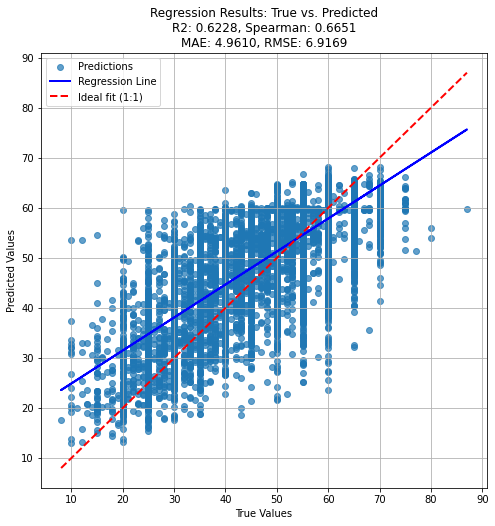

In [27]:
from scipy.stats import spearmanr, linregress
from torchmetrics import R2Score, MeanAbsoluteError, MeanSquaredError
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_regression_results_with_metrics(model=None, test_dataloader=None, y_true=None, y_pred=None):
    device = 'cuda:0'

    if model is not None: 
        model.eval()  # Set the model to evaluation mode
        y_true = []
        y_pred = []
    
        with torch.no_grad():  # Disable gradient calculation for evaluation
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                outputs = outputs.squeeze()  # Ensure the outputs are in the correct shape
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.cpu().numpy())

        # Convert lists to numpy arrays
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

    # Calculate R2 score
    r2_metric = R2Score().to(device)
    r2_metric.update(torch.tensor(y_pred), torch.tensor(y_true))
    r2_value = r2_metric.compute().item()

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(y_true, y_pred)

    # Calculate additional metrics: MAE and RMSE
    mae_metric = MeanAbsoluteError().to(device)
    mse_metric = MeanSquaredError(squared=False).to(device)  # RMSE

    mae_metric.update(torch.tensor(y_pred), torch.tensor(y_true))
    mse_metric.update(torch.tensor(y_pred), torch.tensor(y_true))

    mae_value = mae_metric.compute().item()
    rmse_value = mse_metric.compute().item()

    # Linear regression for the regression line
    slope, intercept, _, _, _ = linregress(y_true, y_pred)
    regression_line = slope * y_true + intercept

    # Plotting the true values vs predicted values
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, label="Predictions", alpha=0.7)
    plt.plot(y_true, regression_line, 'b-', lw=2, label="Regression Line")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label="Ideal fit (1:1)")

    # Add labels, title, and metrics
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(
        f"Regression Results: True vs. Predicted\n"
        f"R2: {r2_value:.4f}, Spearman: {spearman_corr:.4f}\n"
        f"MAE: {mae_value:.4f}, RMSE: {rmse_value:.4f}"
    )
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_lvef_reg(results_key, root_dir='/volume/deepecg/fairseq-signals/outputs', subset='test'):
    results_path = get_path(results_key, root_dir)
    header_pkl=f"{results_path}/outputs_{subset}_header.pkl"
    header_npy=f"{results_path}/outputs_{subset}.npy"
    header = np.load(header_pkl, allow_pickle=True)
    y_pred = np.memmap(header_npy, 
        mode='r',
        shape=header['shape'],
        dtype=header['dtype']
    )
    df = pd.read_csv('/media/data1/ravram/DeepECG_Datasets/test_filtered_lite_LVEF_Continuous.csv')
    y_true = df['Visually Estimated EF_tte_lvef'].to_numpy()
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    print(y_pred.shape, y_true.shape)
    
    plot_regression_results_with_metrics(y_pred=y_pred, y_true=y_true)

    
plot_lvef_reg('last-ft-fevg-reg-mse')
        

In [10]:
y = np.load("/media/data1/anolin/for_achille_ssl/NEW_DS/UKB_cleaned_high_pass_scaled/Y_UKB.npy")
y.shape

(54959, 77)

In [ ]:
folders_str = '10:1000:100000'

folder_name_len, skip, total = [int(x) for x in folders_str.split(':')]
#final_list = ['A-Z'] + [str(i*skip).zfill(folder_name_len) for i in range(total)]
final_list = [str(i*skip).zfill(folder_name_len) for i in range(total)]

len(final_list), final_list[:10], final_list[-10:]

In [4]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
from scipy import stats
import numpy as np
import scipy.stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float64)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float64)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float64)
    ty = np.empty([k, n], dtype=np.float64)
    tz = np.empty([k, m + n], dtype=np.float64)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    #order = (~ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test_fast(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)


def delong_roc_test(y_true, probs_model_1, probs_model_2):
    """
    DeLong test for two correlated ROC AUC curves.

    Parameters:
    - y_true: True binary labels (shape: [n_samples])
    - probs_model_1: Predicted probabilities for Model 1 (shape: [n_samples])
    - probs_model_2: Predicted probabilities for Model 2 (shape: [n_samples])

    Returns:
    - p_value: p-value of the DeLong test
    """
    # Calculate AUCs
    fpr1, tpr1, _ = roc_curve(y_true, probs_model_1)
    fpr2, tpr2, _ = roc_curve(y_true, probs_model_2)
    auc1 = auc(fpr1, tpr1)
    auc2 = auc(fpr2, tpr2)

    # Variance estimates for the AUCs
    def auc_variance(y_true, probs):
        sorted_indices = np.argsort(probs)
        y_sorted = y_true[sorted_indices]
        n1 = sum(y_sorted)
        n2 = len(y_sorted) - n1
        v01 = np.cumsum(y_sorted) / n1 / n2
        v10 = np.cumsum(1 - y_sorted) / n1 / n2
        s1 = np.sum(v01[y_sorted == 1]) / n1
        s2 = np.sum(v10[y_sorted == 0]) / n2
        return (s1 * (1 - s1) + s2 * (1 - s2))

    var1 = auc_variance(y_true, probs_model_1)
    var2 = auc_variance(y_true, probs_model_2)
    cov = np.cov(np.column_stack((probs_model_1, probs_model_2)).T)

    # Compute test statistic
    delta = auc1 - auc2
    print(var1, var2, 2*cov[0, 1])
    se = np.sqrt(var1 + var2 - 2 * cov[0, 1])
    z = delta / se

    # Compute two-sided p-value
    p_value = 2 * (1 - stats.norm.cdf(np.abs(z)))
    return p_value




In [17]:
import torch

def afib_ft_results(ft='finetune', folder=''):
    y_labels =  ['label_2y', 'label_5y']
    header_pkl=f"/media/data1/achilsowa/datasets/fairseq/mhi/results/{ft}_afib/{folder}outputs_test_header.pkl"
    header_npy=f"/media/data1/achilsowa/datasets/fairseq/mhi/results/{ft}_afib/{folder}outputs_test.npy"
    parquet_path="/volume/deepecg/ecgs-data/parquet/mhi-afib-test.parquet"
    y_pred, y_true = get_pred_labels(
        header_pkl=header_pkl,
        header_npy=header_npy,
        parquet_path=parquet_path,
        y_labels=y_labels
    )
    return y_pred, y_true

def fevg_ft_results(ft='finetune', folder=''):
    y_labels =  ['LVEF_UNDER_50', 'LVEF_EQUAL_OR_UNDER_40']
    header_pkl=f"/media/data1/achilsowa/datasets/fairseq/mhi/results/{ft}_fevg/{folder}outputs_test_header.pkl"
    header_npy=f"/media/data1/achilsowa/datasets/fairseq/mhi/results/{ft}_fevg/{folder}outputs_test.npy"
    csv_path="/media/data1/ravram/DeepECG_Datasets/test_filtered_echo.csv"
    y_pred, y_true = get_pred_labels(
        header_pkl=header_pkl,
        header_npy=header_npy,
        csv_path=csv_path,
        y_labels=y_labels
    )
    return y_pred, y_true

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def squeeze_res(y, idx, apply_sigmoid=True):
    y = np.squeeze(y[:, idx])
    return sigmoid(y) if apply_sigmoid else y

def get_p_value(data):
    p_value = 10 ** delong_roc_test_fast(
        data['y_true'],
        data['y_pred_FT'],
        data['y_pred_E2E'],
    )
    return p_value

AFIB_E2E_RES = '/media/data1/anolin/alexis_models/for_achille/5YR_AFIB_E2E.npy'
AFIB_E2E_RES = '/media/data1/achilsowa/results/fevg/afib_5_y_prob_E2E_Gilbert.npy'
LVEF_40_E2E_RES = '/media/data1/anolin/alexis_models/for_achille/E2E_40_ECHO_V1.npy'
LVEF_50_E2E_RES = '/media/data1/anolin/alexis_models/for_achille/E2E_50_ECHO_V1.npy'


afib_y_pred, afib_y_true = afib_ft_results(folder='allv1/')
afib_y_pred_le, afib_y_true_le = afib_ft_results(ft='le')
afib_y_true = afib_y_true.astype(int)
afib_y_true_le = afib_y_true_le.astype(int)
fevg_y_pred, fevg_y_true = fevg_ft_results(folder='allv1/')
fevg_y_pred_le, fevg_y_true_le = fevg_ft_results(ft='le')

afib_5 = {
    'y_true': squeeze_res(afib_y_true, 1, False),
    'y_pred_FT': squeeze_res(afib_y_pred, 1,),
    'y_pred_E2E': sigmoid(np.squeeze(np.load(AFIB_E2E_RES))),
    'y_pred_E2E1': squeeze_res(afib_y_pred_le, 1)
}
fevg_50 = {
    'y_true': squeeze_res(fevg_y_true, 0, False),
    'y_pred_FT': squeeze_res(fevg_y_pred, 0,),
    'y_pred_E2E': sigmoid(np.squeeze(np.load(LVEF_50_E2E_RES))),
    'y_pred_E2E1': squeeze_res(fevg_y_pred_le, 0)
}
fevg_40 = {
    'y_true': squeeze_res(fevg_y_true, 1, False),
    'y_pred_FT': squeeze_res(fevg_y_pred, 1,),
    'y_pred_E2E': sigmoid(np.squeeze(np.load(LVEF_40_E2E_RES))),
    'y_pred_E2E1': squeeze_res(fevg_y_pred_le, 1) 
}

p_value_40 = get_p_value(fevg_40)
p_value_50 = get_p_value(fevg_50)
p_value_5 = get_p_value(afib_5)
p_value_40, p_value_50, p_value_5

<ipython-input-3-af4fd378d18f>:27: DtypeWarning: Columns (28,43,51,93,105,107,230,238,239,240,257,258,259,276,277,278,279,280,646,658,692,693,694,695,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,775,800,804,806) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_parquet(parquet_path) if csv_path is None else pd.read_csv(csv_path)
<ipython-input-3-af4fd378d18f>:27: DtypeWarning: Columns (28,43,51,93,105,107,230,238,239,240,257,258,259,276,277,278,279,280,646,658,692,693,694,695,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,775,800,804,806) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_parquet(parquet_path) if csv_path is None else pd.read_csv(csv_path)


(array([[4.49410248e-10]]),
 array([[3.72222238e-31]]),
 array([[5.34697859e-209]]))

In [13]:
np.sum(fevg_40['y_true']), fevg_40['y_true'].shape, np.sum(fevg_40['y_true'])/fevg_40['y_true'].shape[0]
np.sum(afib_5['y_true']), afib_5['y_true'].shape, np.sum(afib_5['y_true'])/afib_5['y_true'].shape[0]

(48845, (166313,), 0.29369321700648776)

In [19]:
from sklearn.metrics import roc_auc_score
import numpy as np


predictions_40_ft = pd.DataFrame({'y_true': fevg_40['y_true'], 'y_pred': fevg_40['y_pred_FT']})
predictions_40_e2e = pd.DataFrame({'y_true': fevg_40['y_true'], 'y_pred': fevg_40['y_pred_E2E']})

predictions_50_ft = pd.DataFrame({'y_true': fevg_50['y_true'], 'y_pred': fevg_50['y_pred_FT']})
predictions_50_e2e = pd.DataFrame({'y_true': fevg_50['y_true'], 'y_pred': fevg_50['y_pred_E2E']})

predictions_5_ft = pd.DataFrame({'y_true': afib_5['y_true'], 'y_pred': afib_5['y_pred_FT']})
predictions_5_e2e = pd.DataFrame({'y_true': afib_5['y_true'], 'y_pred': afib_5['y_pred_E2E']})

def calculate_ci(y_true, y_pred, get_score, n_bootstraps=2000, confidence_level=0.95):
    bootstrapped_scores = []
    rng = np.random.RandomState(42)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(y_true.iloc[indices].unique()) < 2:
            continue
        score = roc_auc_score(y_true.iloc[indices], y_pred.iloc[indices])
        score = get_score(indices)
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    confidence_lower = sorted_scores[int((1.0-confidence_level)/2.0 * len(sorted_scores))]
    confidence_upper = sorted_scores[int((1.0+confidence_level)/2.0 * len(sorted_scores))]

    return confidence_lower, confidence_upper
    

def compute_ci(predictions, title):
    y_true = predictions['y_true'] #predictions['died'] == 'Yes'
    y_pred = predictions['y_pred'] #predictions['Score_Yes']
    y_pred_bool = (y_pred > 0.5).astype(int)
    print('='*10, title, '='*10)
    
    score = roc_auc_score(y_true, y_pred)
    ci_lower, ci_upper = calculate_ci(y_true, y_pred, get_score=lambda indices: roc_auc_score(y_true.iloc[indices], y_pred.iloc[indices]))
    print(f"AUC Score: {score:.3f}")
    print(f"95% Confidence Interval: ({ci_lower:.3f}, {ci_upper:.3f})\n")

    score = average_precision_score(y_true, y_pred)
    ci_lower, ci_upper = calculate_ci(y_true, y_pred, get_score=lambda indices: average_precision_score(y_true.iloc[indices], y_pred.iloc[indices]))
    print(f"AUPRC Score: {score:.3f}")
    print(f"95% Confidence Interval: ({ci_lower:.3f}, {ci_upper:.3f})\n")

    score = f1_score(y_true, y_pred_bool)
    ci_lower, ci_upper = calculate_ci(y_true, y_pred, get_score=lambda indices: f1_score(y_true.iloc[indices], y_pred_bool.iloc[indices]))
    print(f"F1 Score: {score:.3f}")
    print(f"95% Confidence Interval: ({ci_lower:.3f}, {ci_upper:.3f})\n")
    print('\n')



compute_ci(predictions_50_e2e, 'fevg_50_e2e')
compute_ci(predictions_50_ft, 'fevg_50_ft')
compute_ci(predictions_40_e2e, 'fevg_40_e2e')
compute_ci(predictions_40_ft, 'fevg_40_ft')
compute_ci(predictions_5_e2e, 'afib_5_e2e')
compute_ci(predictions_5_ft, 'afib_5_ft')

========== fevg_50_e2e ==========
AUC Score: 0.863
95% Confidence Interval: (0.857, 0.869)

AUPRC Score: 0.478
95% Confidence Interval: (0.460, 0.497)

F1 Score: 0.076
95% Confidence Interval: (0.064, 0.088)



========== fevg_50_ft ==========
AUC Score: 0.888
95% Confidence Interval: (0.882, 0.893)

AUPRC Score: 0.531
95% Confidence Interval: (0.513, 0.550)

F1 Score: 0.446
95% Confidence Interval: (0.428, 0.463)



========== fevg_40_e2e ==========
AUC Score: 0.908
95% Confidence Interval: (0.902, 0.914)

AUPRC Score: 0.456
95% Confidence Interval: (0.433, 0.481)

F1 Score: 0.069
95% Confidence Interval: (0.054, 0.085)



========== fevg_40_ft ==========
AUC Score: 0.921
95% Confidence Interval: (0.916, 0.926)

AUPRC Score: 0.488
95% Confidence Interval: (0.465, 0.513)

F1 Score: 0.302
95% Confidence Interval: (0.280, 0.325)



========== afib_5_e2e ==========
AUC Score: 0.764
95% Confidence Interval: (0.761, 0.766)

AUPRC Score: 0.593
95% Confidence Interval: (0.588, 0.598)

F1 Scor

In [14]:
compute_ci(predictions_5_e2e, 'afib_5_e2e')
compute_ci(predictions_5_ft, 'afib_5_ft')

========== afib_5_e2e ==========
AUC Score: 0.784
95% Confidence Interval: (0.781, 0.786)


AUPRC Score: 0.637
95% Confidence Interval: (0.633, 0.642)


F1 Score: 0.360
95% Confidence Interval: (0.355, 0.365)


========== afib_5_ft ==========
AUC Score: 0.793
95% Confidence Interval: (0.790, 0.795)


AUPRC Score: 0.657
95% Confidence Interval: (0.652, 0.661)


F1 Score: 0.551
95% Confidence Interval: (0.547, 0.555)




In [22]:
from sklearn.metrics import roc_auc_score
import numpy as np


predictions_40_ft = pd.DataFrame({'y_true': fevg_40['y_true'], 'y_pred': fevg_40['y_pred_FT']})
predictions_40_e2e = pd.DataFrame({'y_true': fevg_40['y_true'], 'y_pred': fevg_40['y_pred_E2E']})

predictions_50_ft = pd.DataFrame({'y_true': fevg_50['y_true'], 'y_pred': fevg_50['y_pred_FT']})
predictions_50_e2e = pd.DataFrame({'y_true': fevg_50['y_true'], 'y_pred': fevg_50['y_pred_E2E']})

predictions_5_ft = pd.DataFrame({'y_true': afib_5['y_true'], 'y_pred': afib_5['y_pred_FT']})
predictions_5_e2e = pd.DataFrame({'y_true': afib_5['y_true'], 'y_pred': afib_5['y_pred_E2E']})

def calculate_auc_ci(y_true, y_pred, n_bootstraps=10000, confidence_level=0.95):
    bootstrapped_scores = []
    rng = np.random.RandomState(42)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(y_true.iloc[indices].unique()) < 2:
            continue
        score = roc_auc_score(y_true.iloc[indices], y_pred.iloc[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    confidence_lower = sorted_scores[int((1.0-confidence_level)/2.0 * len(sorted_scores))]
    confidence_upper = sorted_scores[int((1.0+confidence_level)/2.0 * len(sorted_scores))]

    return confidence_lower, confidence_upper

def compute_ci(predictions, title):
    y_true = predictions['y_true'] #predictions['died'] == 'Yes'
    y_pred = predictions['y_pred'] #predictions['Score_Yes']
    auc_score = roc_auc_score(y_true, y_pred)
    ci_lower, ci_upper = calculate_auc_ci(y_true, y_pred)
    print('='*10, title, '='*10)
    print(f"AUC Score: {auc_score:.3f}")
    print(f"95% Confidence Interval: ({ci_lower:.3f}, {ci_upper:.3f})")
    print('\n')


compute_ci(predictions_50_e2e, 'fevg_50_e2e')
compute_ci(predictions_50_ft, 'fevg_50_ft')
compute_ci(predictions_40_e2e, 'fevg_40_e2e')
compute_ci(predictions_40_ft, 'fevg_40_ft')
compute_ci(predictions_5_e2e, 'afib_5_e2e')
compute_ci(predictions_5_ft, 'afib_5_ft')

========== fevg_50_e2e ==========
AUC Score: 0.863
95% Confidence Interval: (0.857, 0.869)


========== fevg_50_ft ==========
AUC Score: 0.872
95% Confidence Interval: (0.866, 0.878)


========== fevg_40_e2e ==========
AUC Score: 0.908
95% Confidence Interval: (0.903, 0.914)


========== fevg_40_ft ==========
AUC Score: 0.907
95% Confidence Interval: (0.901, 0.912)


========== afib_5_e2e ==========
AUC Score: 0.784
95% Confidence Interval: (0.781, 0.786)


========== afib_5_ft ==========
AUC Score: 0.793
95% Confidence Interval: (0.790, 0.795)




In [54]:
import pickle

def get_norm_from_pkl(src_path):
    with open(src_path, 'rb') as file:
        scaler = pickle.load(file)
    normalization = [
        [m for m in scaler.mean_],
        [s for s in scaler.scale_]
    ]
    return normalization


get_norm_from_pkl('/volume/deepecg/ecgs-data/scaler/scaler_mhi_test_12c.pkl')

/root/miniconda3/lib/python3.8/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[[-0.9715034427462325,
  -0.6788408956640279,
  0.2926625252097259,
  0.8251720638572672,
  -0.6320829522895176,
  -0.19308921037565532,
  -1.3551032241335186,
  -1.3572248937810407,
  -1.3422665360288912,
  -1.083116784023882,
  -0.9255352320613058,
  -0.8719802737072347],
 [33.42391299207053,
  33.46199541595675,
  38.40650903349281,
  27.38003799158715,
  31.877639685464683,
  31.907564966369243,
  52.56740812383607,
  72.0190362054157,
  66.74687362901504,
  61.63610788366851,
  51.713746517095274,
  48.27574248978715]]